### Домашнее задание: Разработка рекомендательной системы для музыки на платформе Spotify

#### 1. Предобработка данных и EDA

Необходимо провести анализ данных (Exploratory Data Analysis, EDA) для понимания структуры датасетов и подготовки данных к разработке рекомендательной системы: 
- Загрузка данных и очистка выбросов
- Рассчитайте основные статистики для числовых колонок: среднее, медиану, стандартное отклонение, минимумы и максимумы.
- Проведите корреляционный анализ между различными признаками (например, между valence, energy, danceability и другими признаками).
- Постройте гистограммы и коробочные диаграммы для визуализации распределений числовых признаков.
- Анализ категориальных данных
- Постройте тепловую карту корреляции между признаками.

#### 2. Разработка рекомендательной системы (Контентная фильтрация)

В этой части задания необходимо разработать рекомендательную систему, которая будет основывать свои рекомендации на характеристиках самих песен.
- Построение модели на основе контента. Используйте признаки, чтобы рекомендовать похожие песни по жанрам и стилю.
- Проведите кластеризацию для улучшения рекомендация на основе признаков с использованием алгоритмов, таких как K-means или DBSCAN. Рекомендуйте песни, которые находятся в одном кластере с уже выбранной песней.

#### 3. Построение гибридной модели

Разработайте гибридную рекомендательную систему, которая сочетает контентную фильтрацию и методы кластеризации признаков. Таким образом, рекомендации могут быть основаны как на схожести признаков, так и на принадлежности песен к определённым группам (кластерам).

#### 4. Оценка качества модели

После того как модели будут построены, необходимо провести их оценку.
- Придумайте метрику для оценки качества на тренировочных данных.
- Создайте свой валидационный набор в группе студентов. Каждому из студентов необходимо выбрать по 30 песен, которые ему нравятся. Желательно разных исполнителей. Объедините данные в группе и создайте единый набор.
- Оцените свою модель с помощью метрик precision/recall at K на разных параметрах и объясните полученный результат. 

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import plotly.express as px 
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN  
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import pairwise_distances_argmin_min

Сначало объеденим все датасеты в один 

In [51]:
df_data=pd.read_csv("data/data.csv")
df_data_by_artist=pd.read_csv("data/data_by_artist.csv")
df_data_by_genres=pd.read_csv("data/data_by_genres.csv")
df_data_by_year=pd.read_csv("data/data_by_year.csv")
df_data_w_genres=pd.read_csv("data/data_w_genres.csv")

In [52]:
df_data['artists'] = df_data["artists"].str.replace(r"[\[\]']", "", regex=True)

In [53]:
df_data_by_artist = df_data_by_artist.add_suffix('_artists')
df_data_by_artist = df_data_by_artist.rename(columns={'artists_artists':'artists'})
df_data_by_artist = df_data_by_artist.drop(['mode_artists', 'key_artists'], axis=1)


In [54]:
df_data_w_genres = df_data_w_genres.add_suffix('_genres')
df_data_w_genres = df_data_w_genres.rename(columns={'genres_genres':'genres', 'artists_genres': 'artists'})
df_data_w_genres = df_data_w_genres.drop(['mode_genres', 'key_genres'], axis=1)

In [55]:
df_data_by_year = df_data_by_year.add_suffix('_year')
df_data_by_year = df_data_by_year.rename(columns={'year_year':'year'})
df_data_by_year = df_data_by_year.drop(['mode_year', 'key_year'], axis=1)

In [56]:
merged_df_1 = pd.merge(
    df_data,
    df_data_w_genres,
    on='artists',
    how='outer')

In [57]:
merged_df_final = pd.merge(
    merged_df_1,
    df_data_by_year,
    on='year',
    how='outer')

In [58]:
merged_df_final = merged_df_final.dropna()

In [59]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134780 entries, 1 to 170652
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   valence                  134780 non-null  float64
 1   year                     134780 non-null  float64
 2   acousticness             134780 non-null  float64
 3   artists                  134780 non-null  object 
 4   danceability             134780 non-null  float64
 5   duration_ms              134780 non-null  float64
 6   energy                   134780 non-null  float64
 7   explicit                 134780 non-null  float64
 8   id                       134780 non-null  object 
 9   instrumentalness         134780 non-null  float64
 10  key                      134780 non-null  float64
 11  liveness                 134780 non-null  float64
 12  loudness                 134780 non-null  float64
 13  mode                     134780 non-null  float64
 14  name     

Основные статистики

In [11]:
merged_df_final[merged_df_final.select_dtypes(include=[np.number]).columns].describe()

valence           year   acousticness   danceability  \
count  134780.000000  134780.000000  134780.000000  134780.000000   
mean        0.548725    1978.766004       0.458010       0.545848   
std         0.255805      24.498143       0.365829       0.167415   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.346000    1961.000000       0.078400       0.432000   
50%         0.560000    1980.000000       0.426000       0.554000   
75%         0.761000    1999.000000       0.826000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.347800e+05  134780.000000  134780.000000     134780.000000   
mean   2.267133e+05       0.511902       0.076339          0.139542   
std    1.183179e+05       0.261613       0.265541          0.287589   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.702400e+05       0.295000       0.000000          0.000000   
50%    2.066505e+05       0.507000       0.000000          0.000147   
75%    2.588930e+05       0.727000       0.000000          0.044900   
max    5.403500e+06       1.000000       1.000000          1.000000   

                 key       liveness  ...  danceability_year  duration_ms_year  \
count  134780.000000  134780.000000  ...      134780.000000     134780.000000   
mean        5.207946       0.205627  ...           0.539658     232818.915090   
std         3.518589       0.176310  ...           0.046691      22271.718309   
min         0.000000       0.000000  ...           0.414445     156881.657475   
25%         2.000000       0.098000  ...           0.504253     216095.113000   
50%         5.000000       0.135000  ...           0.541019     241049.962564   
75%         8.000000       0.261000  ...           0.570882     249177.099511   
max        11.000000       1.000000  ...           0.692904     267677.823086   

         energy_year  instrumentalness_year  liveness_year  loudness_year  \
count  134780.000000          134780.000000  134780.000000  134780.000000   
mean        0.500014               0.154581       0.205507     -11.212961   
std         0.143892               0.091448       0.015915       2.770870   
min         0.207948               0.016376       0.168450     -19.275282   
25%         0.341142               0.100381       0.194932     -13.364056   
50%         0.562560               0.115751       0.203010     -11.327479   
75%         0.602435               0.181241       0.215441      -8.312630   
max         0.681778               0.581701       0.264335      -6.595067   

       speechiness_year     tempo_year   valence_year  popularity_year  
count     134780.000000  134780.000000  134780.000000    134780.000000  
mean           0.092727     117.497520       0.534523        33.287759  
std            0.066335       4.824143       0.050293        17.873436  
min            0.049098     100.884521       0.379327         0.140845  
25%            0.060855     114.324587       0.508423        20.773333  
50%            0.076351     119.239738       0.546485        36.206667  
75%            0.093849     120.918607       0.569415        46.684049  
max            0.490001     124.283129       0.663725        65.256542  

[8 rows x 38 columns]

Почистим данные от слишком длинных песен использую Z-скор

In [60]:
def drop_long_songs(df, threshold=3):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs((df[numeric_cols] - df[numeric_cols].mean()) / df[numeric_cols].std())
    df = df[(z_scores < threshold).all(axis=1)]
    return df

In [61]:
merged_df_final = drop_long_songs(merged_df_final)

In [62]:
merged_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105192 entries, 232 to 168622
Data columns (total 43 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   valence                  105192 non-null  float64
 1   year                     105192 non-null  float64
 2   acousticness             105192 non-null  float64
 3   artists                  105192 non-null  object 
 4   danceability             105192 non-null  float64
 5   duration_ms              105192 non-null  float64
 6   energy                   105192 non-null  float64
 7   explicit                 105192 non-null  float64
 8   id                       105192 non-null  object 
 9   instrumentalness         105192 non-null  float64
 10  key                      105192 non-null  float64
 11  liveness                 105192 non-null  float64
 12  loudness                 105192 non-null  float64
 13  mode                     105192 non-null  float64
 14  name   

Визуализируем данные 

In [15]:
def draw_plots_by_num_fitchs(df, num_col = 4):
    i_col = 1
    j_row = 0

    plt.figure(figsize=(20, 60))
    for feat in df.columns:

        if df[feat].dtype == 'object':
            plt.subplot(round(len(df.columns)/num_col) * 2, num_col, num_col * (j_row) + (i_col))
            sns.countplot(x=feat, data = df)
        else:
            plt.subplot(round(len(df.columns)/num_col) * 2, num_col, num_col * (j_row) + (i_col))
            sns.boxplot(df[feat])
            if i_col < num_col:
                i_col = i_col + 1
            else:
                i_col = 1
                j_row = j_row + 1
            plt.subplot(round(len(df.columns)/num_col) * 2, num_col, num_col * (j_row) + (i_col))
            sns.histplot(df[feat], kde=True)

        if i_col < num_col:
            i_col = i_col + 1
        else:
            i_col = 1
            j_row = j_row + 1
    plt.show()

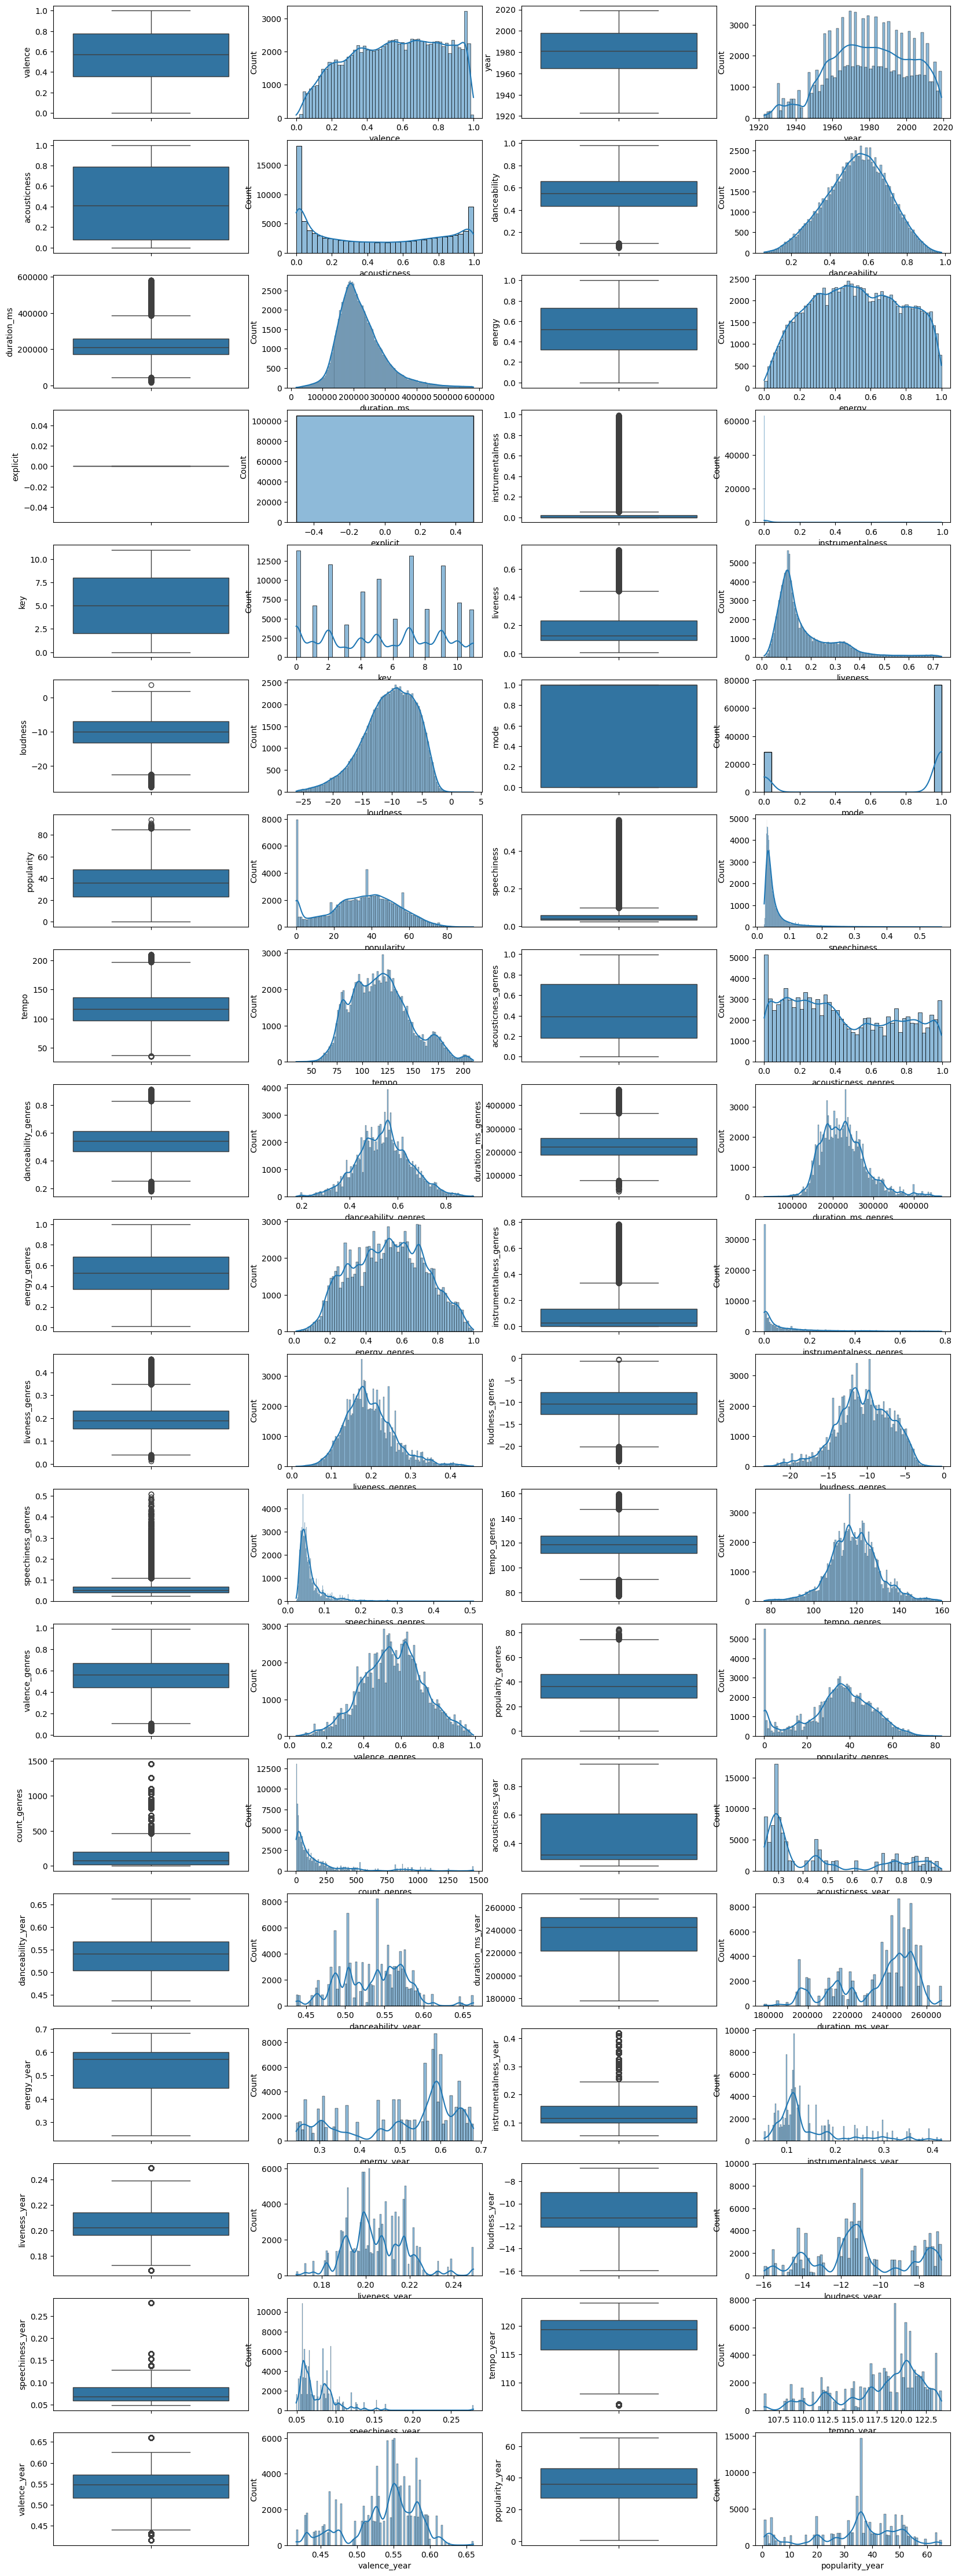

In [16]:
draw_plots_by_num_fitchs(merged_df_final[merged_df_final.select_dtypes(include=[np.number]).columns])

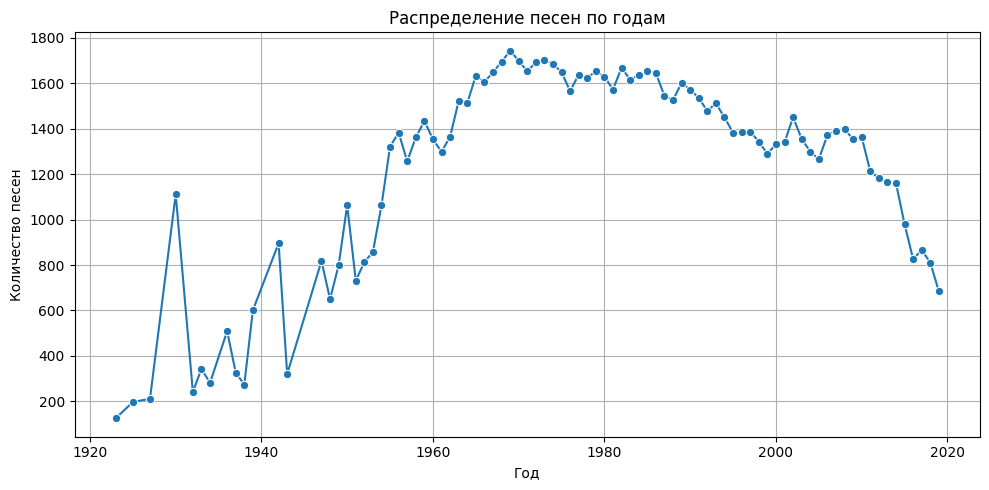

In [ ]:
merged_df_final['year'] = merged_df_final['release_date'].str.split('-').str[0].astype(int)
year_counts = merged_df_final['year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Распределение песен по годам')
plt.xlabel('Год')
plt.ylabel('Количество песен')
plt.grid(True)
plt.tight_layout()
plt.show()

Построим матрицу корреляций (без эксплисит, там булевые значения )

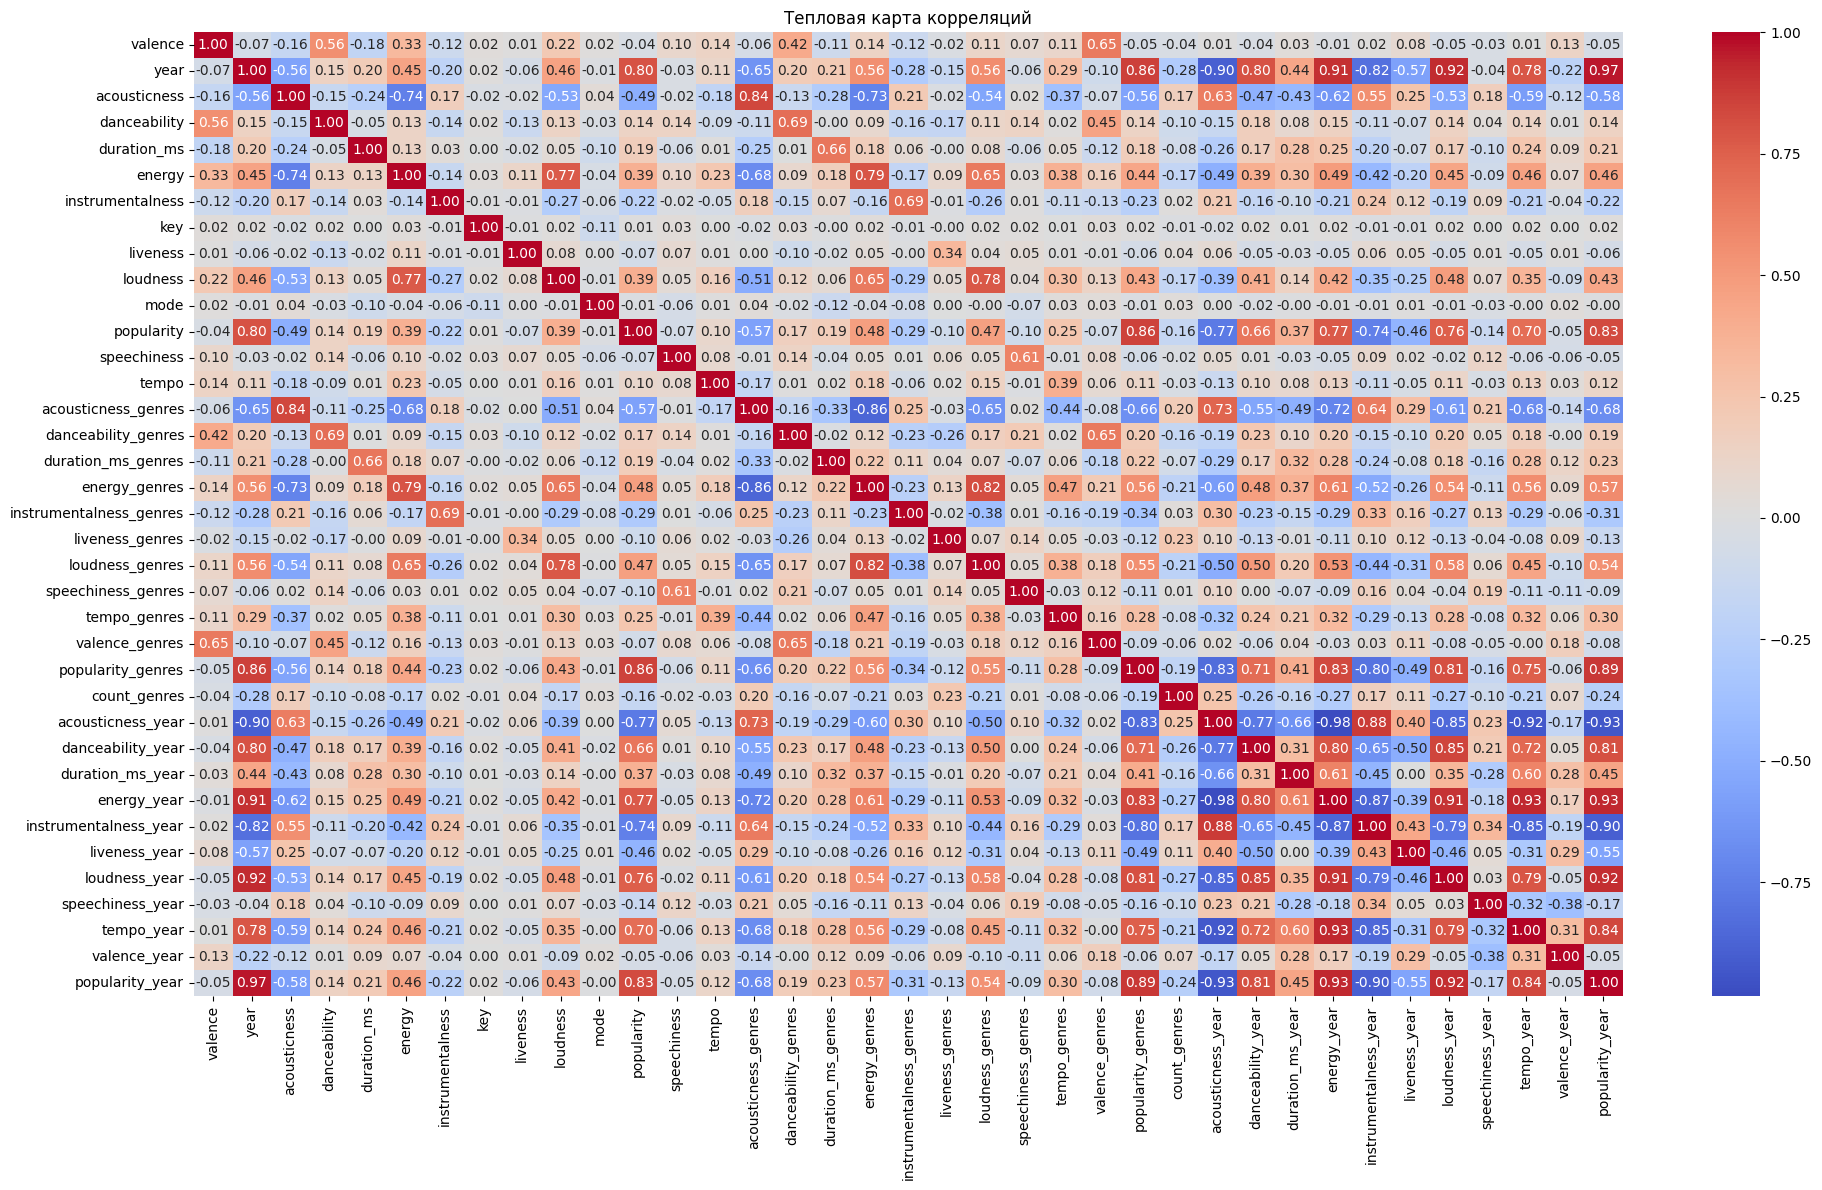

In [64]:
num_col = merged_df_final.select_dtypes(include=[np.number]).columns
correlation_matrix = merged_df_final[num_col.drop("explicit")].corr()

plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Тепловая карта корреляций")
plt.tight_layout()
plt.show()

[]

### Выводы:
Исходя из анализа, я решил выбрать следующие фичи для дальнейшей работы:

- energy (корреляция с популярностью: 0.457876)
Энергичность трека сильно влияет на его популярность. Люди чаще предпочитают более энергичную музыку.

- danceability (корреляция с популярностью: 0.139621)
Танцевальность важна для рекомендаций, так как многие слушатели ищут музыку для движения.

- valence (корреляция с популярностью: -0.053255, но высокая связь с жанрами: 0.645602)
Валентность (позитивность) влияет на настроение трека. Несмотря на слабую связь с популярностью, она важна для персонализации.

- acousticness (корреляция с популярностью: -0.493421)
Акустичность обратно коррелирует с популярностью — электронная музыка чаще популярна, но это важно для рекомендаций в нишевых жанрах.

- loudness (корреляция с популярностью: 0.390101)
Громкость связана с энергичностью и популярностью (люди предпочитают более громкие треки).

- tempo (корреляция с популярностью: 0.115423)
Темп влияет на восприятие музыки (быстрые треки чаще используются в танцевальных жанрах).

- instrumentalness (корреляция с популярностью: -0.219923)
Инструментальность важна для рекомендаций инструментальной музыки (например, lo-fi, классика).

- duration_ms (корреляция с популярностью: 0.185044)
Длительность трека: слишком короткие или длинные треки могут по-разному восприниматься.

- speechiness (корреляция с популярностью: -0.052098)
Наличие вокальных элементов (например, рэп vs. инструментал).

- year (корреляция с популярностью: 0.966309)
Год выпуска — один из самых сильных предикторов популярности (новые треки чаще популярны).

Посмотрим категориальные фичи

Распределение по категориям

In [66]:
cat_col = merged_df_final.select_dtypes(include=['object', 'category']).columns
print("Категориальные переменные:", cat_col)

Категориальные переменные: Index(['artists', 'id', 'name', 'release_date', 'genres'], dtype='object')


In [67]:
merged_df_final[merged_df_final['genres']=='[]']['genres'].count()

6566

In [68]:
merged_df_final = merged_df_final[merged_df_final['genres']!='[]']

C:\Users\user\AppData\Local\Temp\ipykernel_6388\244848439.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for genre, count in genre_counts],


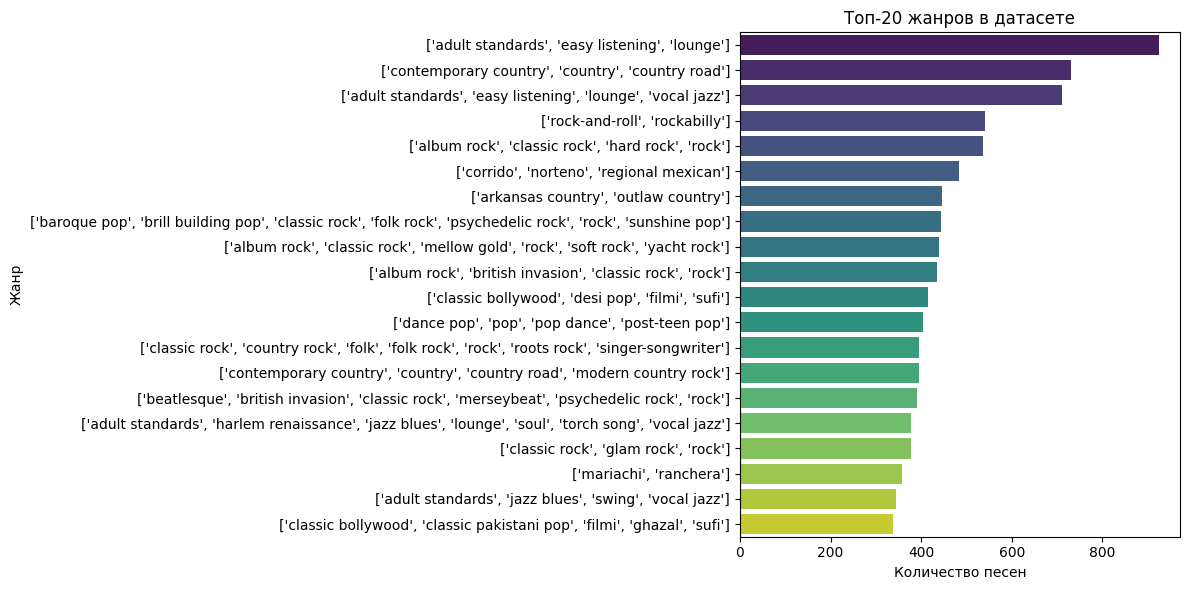

In [ ]:
from collections import Counter

all_genres = [genre for genre in merged_df_final['genres']]
genre_counts = Counter(all_genres).most_common(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[count for genre, count in genre_counts], 
            y=[genre for genre, count in genre_counts], palette='viridis')
plt.title('Топ-20 жанров в датасете')
plt.xlabel('Количество песен')
plt.ylabel('Жанр')
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_6388\4135929445.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=artist_counts.values, y=artist_counts.index, palette='magma')


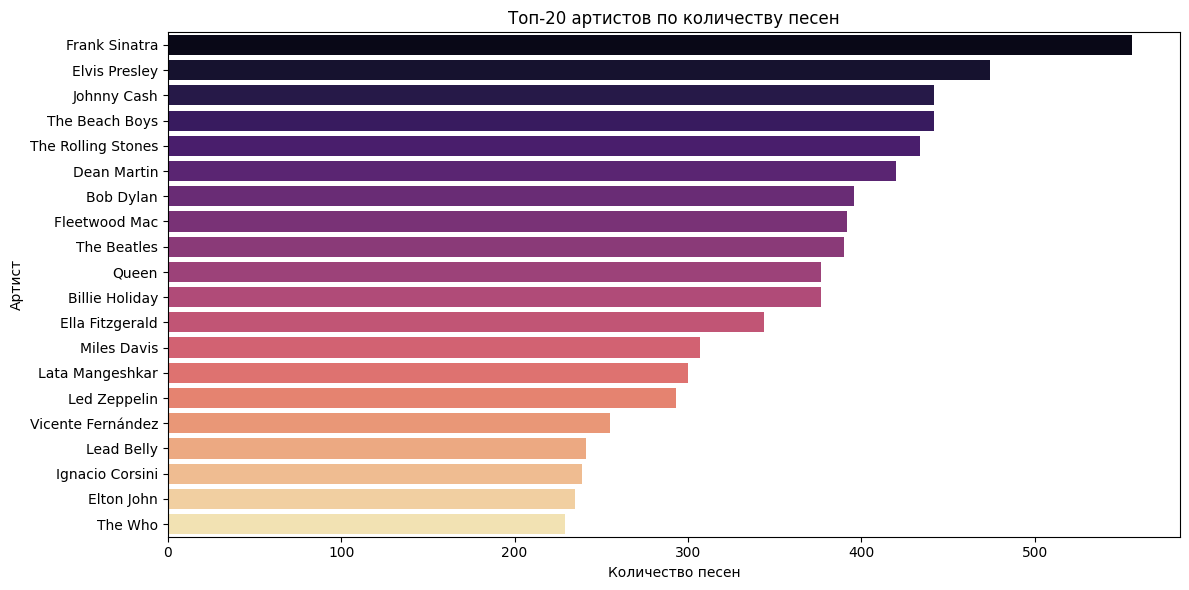

In [ ]:
artist_counts = merged_df_final['artists'].value_counts().head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=artist_counts.values, y=artist_counts.index, palette='magma')
plt.title('Топ-20 артистов по количеству песен')
plt.xlabel('Количество песен')
plt.ylabel('Артист')
plt.tight_layout()
plt.show()

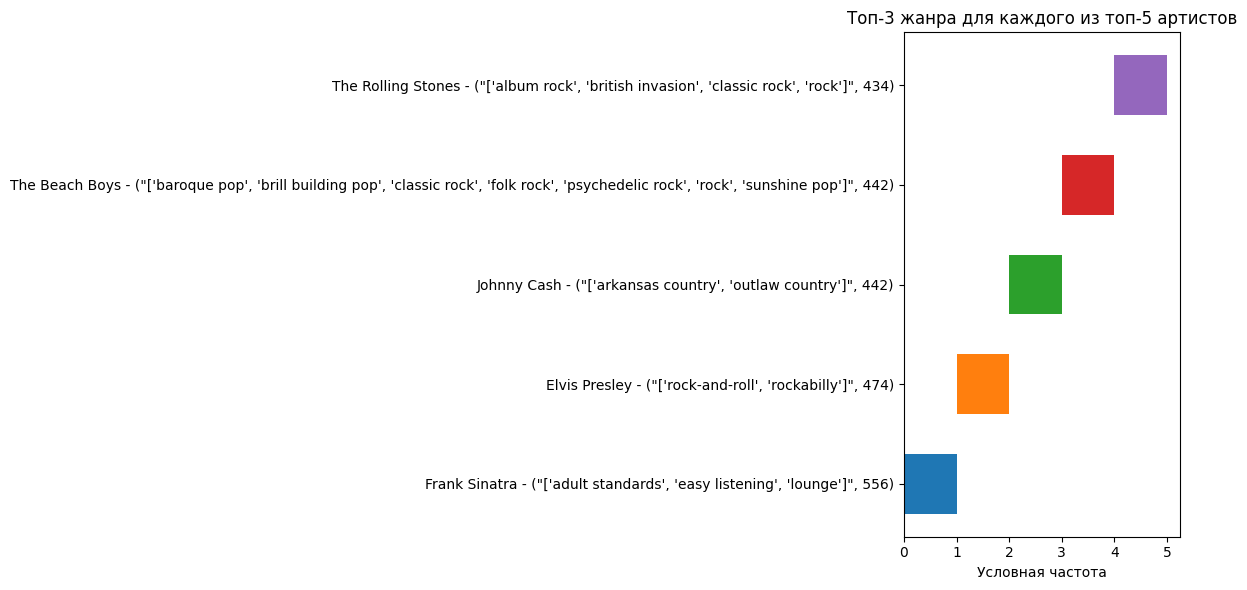

In [ ]:
top_artists = artist_counts.head(5).index.tolist()
artist_genre_map = {}

for artist in top_artists:
    genres = [genre for genre in merged_df_final[merged_df_final['artists'] == artist]['genres']]
    top_genres = Counter(genres).most_common(3)
    artist_genre_map[artist] = [genre for genre in top_genres]

plt.figure(figsize=(12, 6))
for i, (artist, genres) in enumerate(artist_genre_map.items()):
    plt.barh([f"{artist} - {genre}" for genre in genres], 
             [1]*len(genres), 
             left=i, height=0.6)
plt.title('Топ-3 жанра для каждого из топ-5 артистов')
plt.xlabel('Условная частота')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Выводы:
Немного почистили датасет от пустых значений и посмотрели на распределения
Я считаю, что нужны фичи genres, artists

In [72]:
merged_df_final.to_csv('data/merged_df_final.csv', index=False)

In [73]:
merged_df_final = pd.read_csv('data/merged_df_final.csv')

### Рекомендательная система

 Подготовим данные 

In [ ]:
#audio_num_features = ['loudness','danceability', 'energy','energy_year', 'speechiness','popularity', 'tempo', 'year', 'acousticness_year','danceability_genres']
audio_num_features = ['energy', 
                      'danceability', 
                      'popularity',
                      'acousticness', 
                      'loudness', 
                      'tempo',
                      'acousticness_genres',
                      'danceability_genres',
                      'popularity_genres',
                      'acousticness_year', 
                      'energy_year',
                      'instrumentalness', 
                      'year'
                      ]

audio_cat_features = ["artists",
                      "genres"] #хотел ещё и категориальные сделать, но у меня как-то их заэнкодить не получилось... :c

In [29]:
len(merged_df_final['artists'].unique())

10348

In [30]:
len(merged_df_final['genres'].unique())

7027

In [117]:
def preprocess_data(df, num_feat):
    df = df.copy() 
    # cat_pipeline = Pipeline([
    #     ('tfidf', TfidfVectorizer(max_features=5000)),  
    #     ('svd', TruncatedSVD(n_components=50))     
    # ])
    # genre_pipeline = Pipeline([
    #     ('mlb', FunctionTransformer(lambda x: MultiLabelBinarizer().fit_transform(x))),               
    #     ('pca', PCA(n_components=50))                 
    # ])
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())  
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_pipeline, num_feat)
    ])
    preproc_features = preprocessor.fit_transform(df)
    preproc_df = pd.DataFrame(preproc_features, columns=num_feat, index=df.index)

    return preproc_df, preprocessor

# Предобработка основного датасета
main_df, preprocessor = preprocess_data(merged_df_final, audio_num_features)

Кластеризация

попробуем K_means

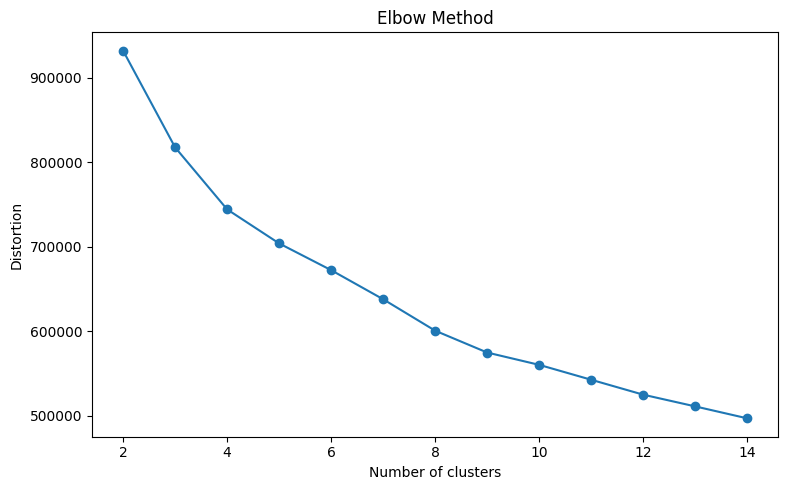

In [ ]:
def find_optimal_clusters(data, max_k=15):
    distortions = []
    
    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state=42)  
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    
    # Визуализация метода локтя
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')

    
    plt.tight_layout()
    plt.show()

find_optimal_clusters(main_df)

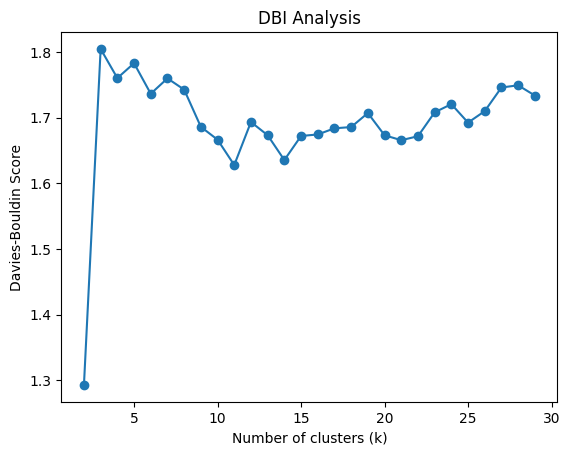

In [90]:
from sklearn.metrics import davies_bouldin_score

db_scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(main_df)
    score = davies_bouldin_score(main_df, labels)
    db_scores.append(score)

plt.plot(range(2, 30), db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.title('DBI Analysis')
plt.show()

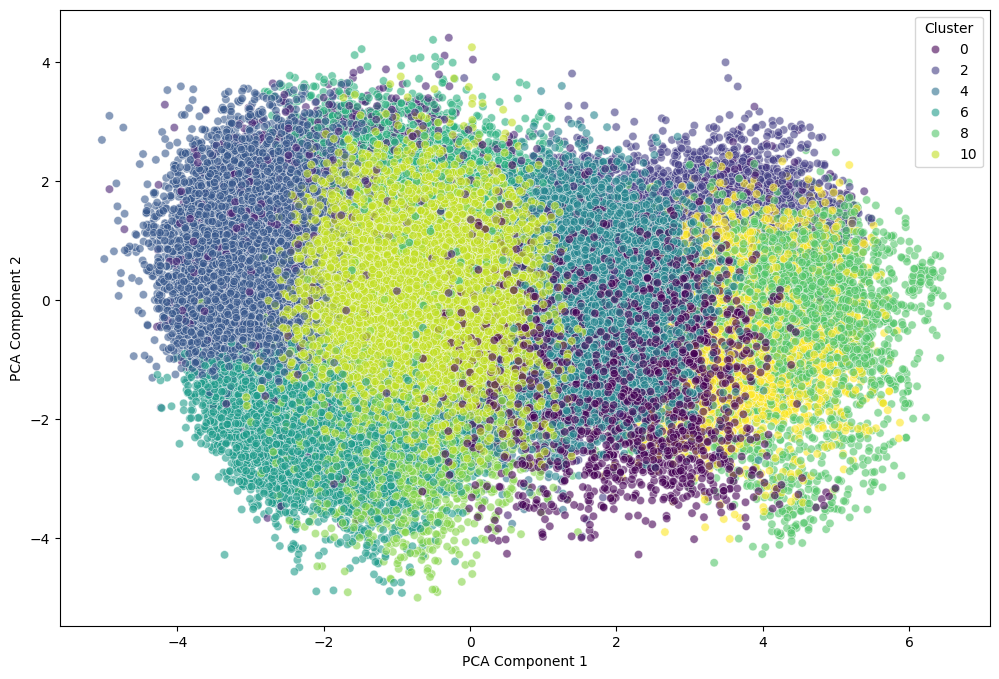

In [ ]:
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(main_df)

main_df = main_df.copy()
main_df.loc[:, 'cluster'] = clusters

# Визуализация кластеров с PCA
def visualize_clusters_PCA(data, features, clusters):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(data[features])
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=clusters, palette='viridis', alpha=0.6)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

visualize_clusters_PCA(main_df, audio_num_features, clusters)

In [ ]:
validation_df = pd.read_csv('data/users_preference_data.csv')
validation_df['artists'] = validation_df["artists"].str.replace(r"[\[\]']", "", regex=True)
validation_df=pd.merge(
    merged_df_final,
    validation_df[['id', 'user_name','user_ID']],
    on='id',
    how='inner')
validation_df.to_csv("data/valid_df.csv")

In [ ]:
class ContentBasedRecommender:
    def __init__(self, data, features, preprocessor, 
                 n_neighbors=20, cluster_method=None, n_clusters=12):

        self.data = data.copy()
        self.features = features
        self.preprocessor = preprocessor
        self.n_neighbors = min(n_neighbors, len(data)-1)
        self.cluster_method = cluster_method
        self.n_clusters = n_clusters
        self.model = None
        self.clusterer = None
        self.cluster_centers_ = None
        
        # Подготовка фичей
        self.scaled_features = self.preprocessor.transform(self.data[self.features])
        
        # Кластеризация (если указана)
        if self.cluster_method:
            self._perform_clustering()
    
    def _perform_clustering(self):
        try:
            if self.cluster_method == 'kmeans':
                self.clusterer = KMeans(n_clusters=self.n_clusters, random_state=42, n_init=10)
                clusters = self.clusterer.fit_predict(self.scaled_features)
                self.cluster_centers_ = self.clusterer.cluster_centers_
                
            elif self.cluster_method == 'dbscan':
                self.clusterer = DBSCAN(eps=0.5, min_samples=5)
                clusters = self.clusterer.fit_predict(self.scaled_features)
                
            elif self.cluster_method == 'hdbscan':
                self.clusterer = HDBSCAN(min_cluster_size=5, min_samples=2)
                clusters = self.clusterer.fit_predict(self.scaled_features)
                
            self.data['cluster'] = clusters
            
        except Exception as e:
            print(f"Ошибка кластеризации: {e}. Продолжаем без кластеризации.")
            self.cluster_method = None
    
    def fit(self):
        try:
            self.model = NearestNeighbors(
                n_neighbors=self.n_neighbors + 1,  # +1 чтобы исключить саму песню
                metric='cosine',
                algorithm='auto'
            )
            self.model.fit(self.scaled_features)
        except Exception as e:
            print(f"Ошибка при обучении модели: {e}")
            raise
    
    def recommend(self, song_id, n_recommendations=5, use_clusters=False):
        try:
            song_idx = self.data[self.data['id'] == song_id].index[0]
            song_features = self.scaled_features[song_idx].reshape(1, -1)
            
            # Если используем кластеры и они есть
            if use_clusters and self.cluster_method is not None:
                # 1. Находим ближайшие кластеры (для KMeans)
                if self.cluster_method == 'kmeans':
                    cluster_distances = cosine_similarity(
                        song_features,
                        self.cluster_centers_
                    ).flatten()
                    closest_clusters = np.argsort(cluster_distances)[-2:][::-1]  # Берем 2 ближайших
                    
                    # Фильтруем данные по кластерам
                    cluster_data = self.data[self.data['cluster'].isin(closest_clusters)]
                    if len(cluster_data) > n_recommendations:
                        # Перестраиваем NearestNeighbors для кластера
                        cluster_features = self.scaled_features[cluster_data.index]
                        cluster_model = NearestNeighbors(
                            n_neighbors=min(n_recommendations+1, len(cluster_data)),
                            metric='cosine'
                        )
                        cluster_model.fit(cluster_features)
                        
                        # Ищем соседей в кластере
                        distances, indices = cluster_model.kneighbors(song_features)
                        rec_indices = cluster_data.iloc[indices[0][1:]].index
                        return self.data.loc[rec_indices, 'id'].tolist()[:n_recommendations]
            
            # Стандартный поиск соседей (если кластеры не используются или их мало)
            distances, indices = self.model.kneighbors(song_features)
            return self.data.iloc[indices[0][1:n_recommendations+1]]['id'].tolist()
            
        except Exception as e:
            print(f"Ошибка при генерации рекомендаций: {e}")
            return []

In [ ]:
class HybridRecommender:
    def __init__(self, df, features, preprocessor, 
                 cluster_method='kmeans', n_clusters=10,
                 min_cluster_size=5):
        self.df = df.copy()
        self.features = features
        self.preprocessor = preprocessor
        self.cluster_method = cluster_method
        self.n_clusters = n_clusters
        self.min_cluster_size = min_cluster_size
        self.cluster_dict = defaultdict(list)
        self.centroids = None
        
        # Подготовка данных
        self.feature_matrix = self.preprocessor.transform(self.df[self.features])
        
        # Кластеризация
        self._perform_clustering()
        
        # Построение индекса для быстрого поиска
        self._build_index()
    
    def _perform_clustering(self):
        if self.cluster_method == 'hdbscan':
            self.clusterer = HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=2,
                cluster_selection_method='eom'
            )
            clusters = self.clusterer.fit_predict(self.feature_matrix)
        elif self.cluster_method == 'dbscan':
            self.clusterer = DBSCAN(
                eps=0.5, 
                min_samples=self.min_cluster_size
            )
            clusters = self.clusterer.fit_predict(self.feature_matrix)
        else:  # kmeans по умолчанию
            self.clusterer = KMeans(
                n_clusters=self.n_clusters, 
                random_state=42,
                n_init=10
            )
            clusters = self.clusterer.fit_predict(self.feature_matrix)
        
        self.df['cluster'] = clusters
        
        # Создаем словарь кластеров
        for idx, row in self.df.iterrows():
            self.cluster_dict[row['cluster']].append(idx)
        
        # Вычисляем центроиды (для kmeans и средние векторы для других методов)
        self._calculate_centroids()
    
    def _calculate_centroids(self):
        self.centroids = {}
        unique_clusters = self.df['cluster'].unique()
        
        for cluster in unique_clusters:
            if cluster == -1:  # пропускаем шумовые точки
                continue
                
            cluster_indices = self.cluster_dict[cluster]
            if len(cluster_indices) > 0:
                self.centroids[cluster] = self.feature_matrix[cluster_indices].mean(axis=0)
    
    def _build_index(self):
        self.nn_model = NearestNeighbors(
            n_neighbors=min(50, len(self.df)),
            metric='cosine',
            algorithm='auto'
        )
        self.nn_model.fit(self.feature_matrix)
    
    def content_based_recommend(self, song_id, n_recommendations=5):
        try:
            song_idx = self.df[self.df['id'] == song_id].index[0]
            song_features = self.feature_matrix[song_idx].reshape(1, -1)
            
            distances, indices = self.nn_model.kneighbors(song_features)
            recommendations = []
            
            for dist, idx in zip(distances[0], indices[0]):
                if idx != song_idx:  # Исключаем исходную песню
                    rec = self.df.iloc[idx].copy()
                    rec['content_similarity'] = 1 - dist
                    recommendations.append(rec)
                if len(recommendations) >= n_recommendations * 3:  # Берем с запасом
                    break
            
            return pd.DataFrame(recommendations)
        except Exception as e:
            print(f"Ошибка в content_based_recommend: {e}")
            return pd.DataFrame()
    
    def cluster_based_recommend(self, song_id, n_recommendations=5):
        try:
            song_cluster = self.df[self.df['id'] == song_id]['cluster'].values[0]
            
            # Для шумовых кластеров используем контентные рекомендации
            if song_cluster == -1:
                return self.content_based_recommend(song_id, n_recommendations)
            
            # Получаем песни кластера (убедимся, что индексы сохраняются)
            cluster_indices = self.cluster_dict.get(song_cluster, [])
            if not cluster_indices:
                return pd.DataFrame()
                
            cluster_songs = self.df.iloc[cluster_indices].copy()
            
            # Фильтрация исходной песни (сохраняем индексы)
            cluster_songs = cluster_songs[cluster_songs['id'] != song_id]
            if len(cluster_songs) == 0:
                return pd.DataFrame()
            
            # Вычисляем схожесть только для оставшихся песен
            remaining_indices = cluster_songs.index
            cluster_features = self.feature_matrix[remaining_indices]
            
            # Для KMeans используем центроиды, для других методов - средний вектор
            if hasattr(self, 'centroids') and song_cluster in self.centroids:
                centroid = self.centroids[song_cluster].reshape(1, -1)
            else:
                centroid = cluster_features.mean(axis=0).reshape(1, -1)
            
            # Вычисляем схожесть (гарантируем одинаковую длину)
            similarities = cosine_similarity(cluster_features, centroid).flatten()
            cluster_songs['cluster_similarity'] = similarities
            
            # Учет популярности (если есть)
            if 'popularity' in cluster_songs.columns:
                cluster_songs['popularity_norm'] = MinMaxScaler().fit_transform(
                    cluster_songs[['popularity']]
                )
                cluster_songs['cluster_score'] = (
                    0.7 * cluster_songs['cluster_similarity'] +
                    0.3 * cluster_songs['popularity_norm']
                )
                cluster_songs = cluster_songs.sort_values('cluster_score', ascending=False)
            else:
                cluster_songs = cluster_songs.sort_values('cluster_similarity', ascending=False)
            
            return cluster_songs.head(n_recommendations * 3)
        
        except Exception as e:
            print(f"Ошибка в cluster_based_recommend: {e}")
            return pd.DataFrame()
    
    def hybrid_recommend(self, song_id, n_recommendations=5, 
                         content_weight=0.6, use_diversity=False):
        try:
            # Получаем рекомендации обоими методами
            content_rec = self.content_based_recommend(song_id, n_recommendations)
            cluster_rec = self.cluster_based_recommend(song_id, n_recommendations)
            
            if content_rec.empty or cluster_rec.empty:
                return content_rec if not content_rec.empty else cluster_rec
            
            # Объединяем рекомендации
            merged_rec = pd.merge(
                content_rec, 
                cluster_rec, 
                on='id', 
                how='outer', 
                suffixes=('_content', '_cluster')
            )
            
            # Заполняем пропуски средними значениями
            for col in ['content_similarity', 'cluster_similarity']:
                if col in merged_rec.columns:
                    merged_rec[col] = merged_rec[col].fillna(merged_rec[col].mean())
            
            # Вычисляем гибридный скор
            merged_rec['hybrid_score'] = (
                content_weight * merged_rec['content_similarity'] + 
                (1 - content_weight) * merged_rec['cluster_similarity']
            )
            
            # Учет разнообразия рекомендаций
            if use_diversity:
                rec_features = np.vstack(merged_rec['id'].apply(
                    lambda x: self.feature_matrix[self.df[self.df['id'] == x].index[0]]
                ).tolist())
                
                similarity_matrix = cosine_similarity(rec_features)
                np.fill_diagonal(similarity_matrix, 0)
                
                # Штрафуем за схожесть с другими рекомендациями
                diversity_penalty = 0.1 * np.sum(similarity_matrix, axis=1)
                merged_rec['hybrid_score'] -= diversity_penalty
            
            # Удаляем дубликаты и сортируем
            final_rec = merged_rec.sort_values('hybrid_score', ascending=False)
            final_rec = final_rec[~final_rec['id'].duplicated()]
            
            return final_rec.head(n_recommendations)
        except Exception as e:
            print(f"Ошибка в hybrid_recommend: {e}")
            return pd.DataFrame()
    
    def get_cluster_stats(self):
        stats = self.df['cluster'].value_counts().reset_index()
        stats.columns = ['cluster', 'count']
        stats['percentage'] = (stats['count'] / len(self.df)) * 100
        return stats

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate_metrics(recommender, test_data, max_k=20):
    k_range = range(1, max_k + 1)
    precisions = {k: [] for k in k_range}
    recalls = {k: [] for k in k_range}
    
    user_liked_songs = {}
    for _, row in test_data.iterrows():
        user_id = row['user_ID']
        song_id = row['id']
        if user_id not in user_liked_songs:
            user_liked_songs[user_id] = set()
        user_liked_songs[user_id].add(song_id)
    
    song_to_users = {}
    for _, row in test_data.iterrows():
        song_id = row['id']
        user_id = row['user_ID']
        if song_id not in song_to_users:
            song_to_users[song_id] = []
        song_to_users[song_id].append(user_id)
    
    for song_id in tqdm(song_to_users, desc="Evaluating songs"):
        users_who_liked = song_to_users[song_id]
        
        try:
            if isinstance(recommender, ContentBasedRecommender):
                recs = recommender.recommend(song_id, n_recommendations=max_k)
            else:
                rec_result = recommender.hybrid_recommend(song_id, n_recommendations=max_k)
                recs = rec_result['id'].tolist() if isinstance(rec_result, pd.DataFrame) else []
            
            for user_id in users_who_liked:
                liked_songs = user_liked_songs[user_id]
                
                for k in k_range:
                    top_k_recs = recs[:k]
                    hits = len(set(top_k_recs) & liked_songs)
                    
                    precisions[k].append(hits / k)
                    recalls[k].append(hits / len(liked_songs) if len(liked_songs) > 0 else 0)
                    
        except Exception as e:
            print(f"Ошибка при рекомендации для песни {song_id}: {e}")
            for user_id in users_who_liked:
                for k in k_range:
                    precisions[k].append(0)
                    recalls[k].append(0)
    
    avg_precisions = {k: np.mean(precisions[k]) for k in k_range}
    avg_recalls = {k: np.mean(recalls[k]) for k in k_range}
    
    # Построение графиков
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(list(k_range), list(avg_recalls.values()), marker='o', color='blue')
    plt.title('Recall@k')
    plt.xlabel('k')
    plt.ylabel('Recall')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(list(k_range), list(avg_precisions.values()), marker='o', color='red')
    plt.title('Precision@k')
    plt.xlabel('k')
    plt.ylabel('Precision')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    # Вывод таблицы для k=5 и k=10
    print("\nТаблица метрик:")
    table_data = {
        "k": [5, 10],
        "Precision@k": [avg_precisions[5], avg_precisions[10]],
        "Recall@k": [avg_recalls[5], avg_recalls[10]]
    }
    display(pd.DataFrame(table_data))

    return {
        "precision": avg_precisions,
        "recall": avg_recalls
    }

Evaluating songs: 100%|██████████| 216/216 [00:02<00:00, 72.12it/s]


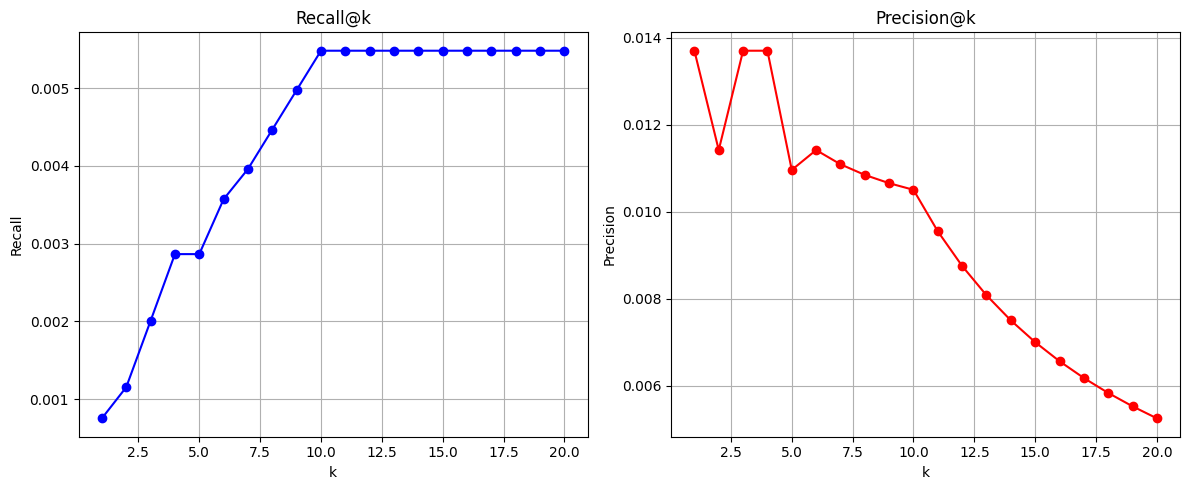


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.010959  0.002865
1  10     0.010502  0.005482

Evaluating songs: 100%|██████████| 216/216 [00:09<00:00, 23.96it/s]


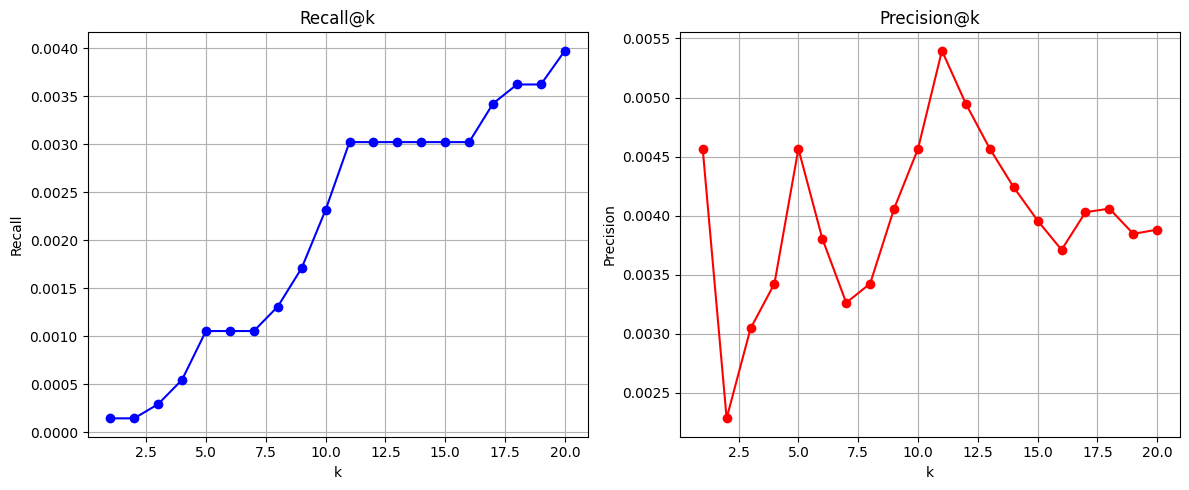


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.004566  0.001056
1  10     0.004566  0.002315

In [138]:
audio_num_features = ['energy', 
                      'danceability', 
                      'popularity',
                      'acousticness', 
                      'loudness', 
                      'tempo',
                      'acousticness_genres',
                      'danceability_genres',
                      'popularity_genres',
                      'acousticness_year', 
                      'energy_year',
                      'instrumentalness', 
                      'year']
_, preprocessor = preprocess_data(merged_df_final, audio_num_features)

content_rec = ContentBasedRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    n_neighbors=10,
    n_clusters=50
)
content_rec.fit()
hybrid_rec = HybridRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    cluster_method='kmeans',
    n_clusters=50
)

content_metrics = evaluate_metrics(content_rec, validation_df)
hybrid_metrics = evaluate_metrics(hybrid_rec, validation_df)

Evaluating songs: 100%|██████████| 216/216 [00:02<00:00, 83.66it/s]


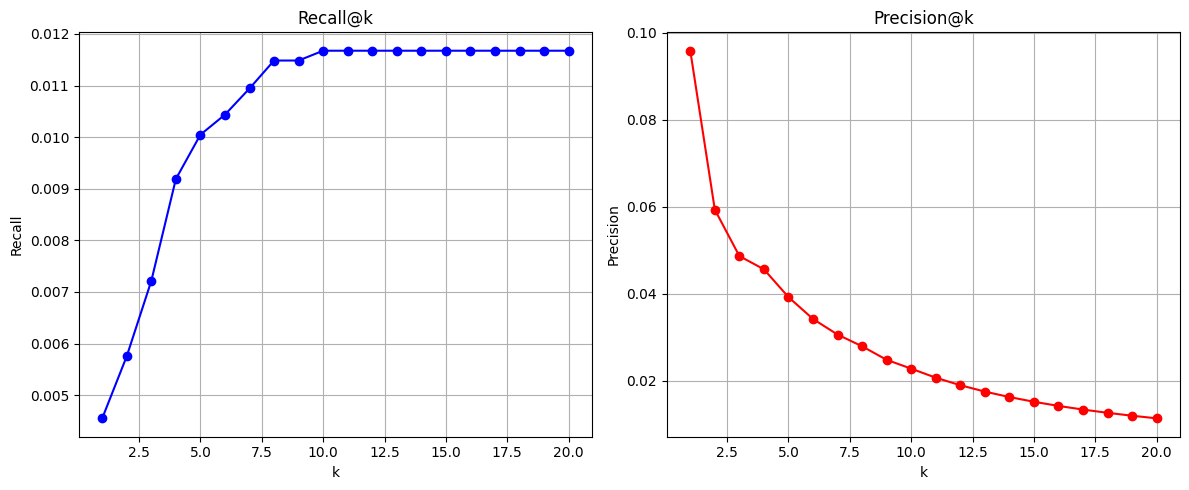


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.039269  0.010048
1  10     0.022831  0.011676

Evaluating songs: 100%|██████████| 216/216 [00:10<00:00, 20.49it/s]


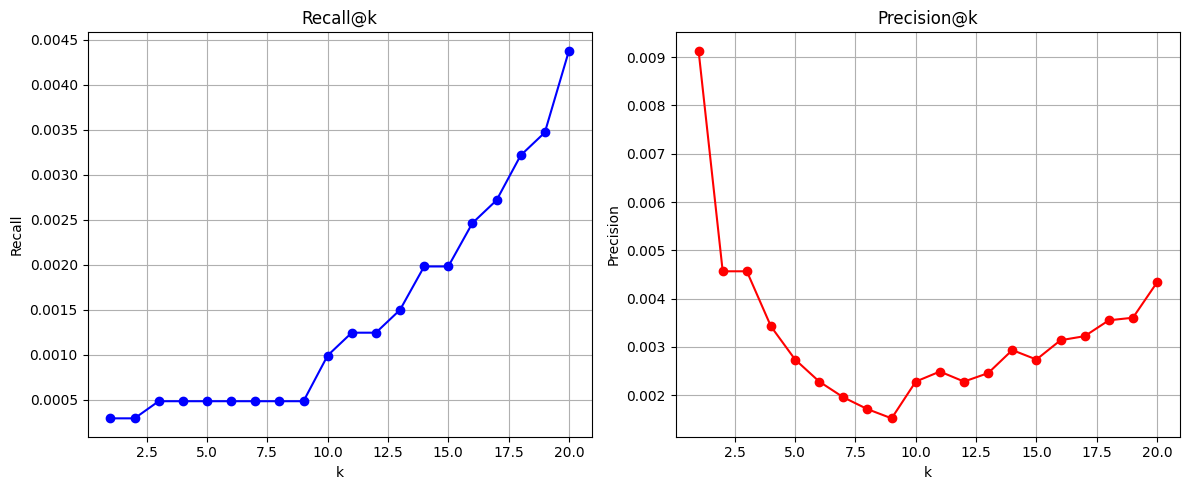


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.002740  0.000485
1  10     0.002283  0.000992

In [139]:
audio_num_features = ['energy', 
                      'loudness', 
                      'tempo',
                      'acousticness_genres',
                      'danceability_genres',
                      'popularity_genres',
                      'acousticness_year', 
                      'energy_year',
                      'instrumentalness', 
                      'year']
_, preprocessor = preprocess_data(merged_df_final, audio_num_features)

content_rec = ContentBasedRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    n_neighbors=10,
    n_clusters=10
)
content_rec.fit()
hybrid_rec = HybridRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    cluster_method='kmeans',
    n_clusters=10
)

content_metrics = evaluate_metrics(content_rec, validation_df)
hybrid_metrics = evaluate_metrics(hybrid_rec, validation_df)

Evaluating songs: 100%|██████████| 216/216 [00:02<00:00, 82.59it/s]


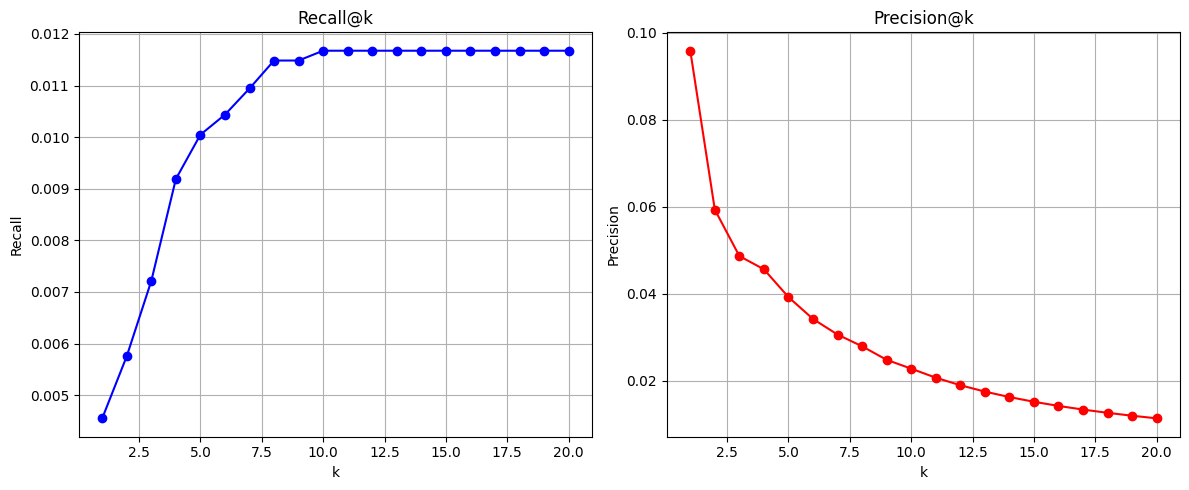


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.039269  0.010048
1  10     0.022831  0.011676

Evaluating songs: 100%|██████████| 216/216 [00:08<00:00, 26.65it/s]


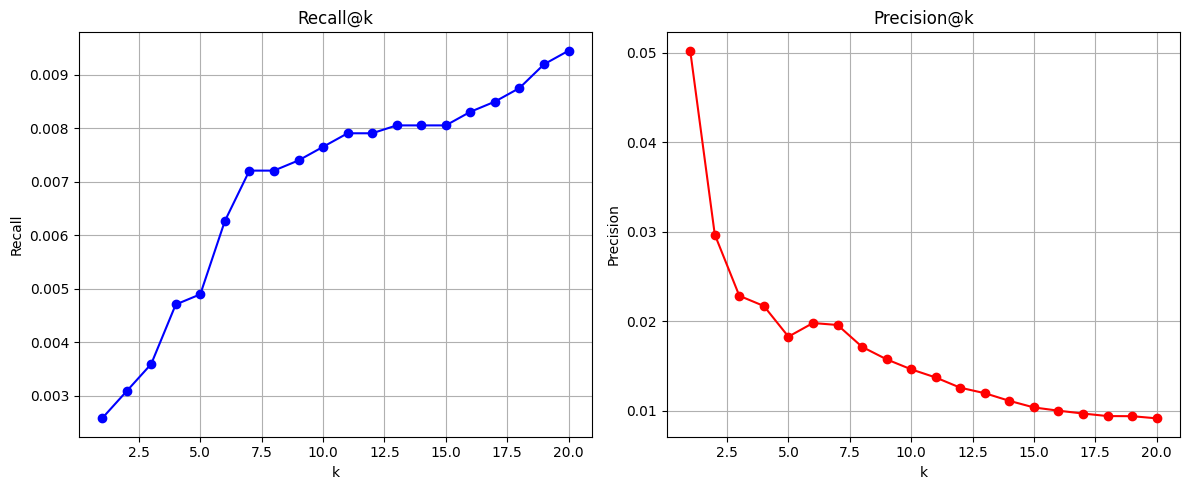


Таблица метрик:


k  Precision@k  Recall@k
0   5     0.018265  0.004895
1  10     0.014612  0.007650

In [ ]:
audio_num_features = ['energy', 
                      'loudness', 
                      'tempo',
                      'acousticness_genres',
                      'danceability_genres',
                      'popularity_genres',
                      'acousticness_year', 
                      'energy_year',
                      'instrumentalness', 
                      'year']
_, preprocessor = preprocess_data(merged_df_final, audio_num_features)

content_rec = ContentBasedRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    n_neighbors=10,
    n_clusters=100
)
content_rec.fit()
hybrid_rec = HybridRecommender(
    merged_df_final,
    features=audio_num_features,
    preprocessor=preprocessor,
    cluster_method='kmeans',
    n_clusters=1000
)

content_metrics = evaluate_metrics(content_rec, validation_df)
hybrid_metrics = evaluate_metrics(hybrid_rec, validation_df)

К большому сожалению, это лучшее, чего смог добиться :c